# Sentiment Analysis for Hayuk


Code below still need many improvement !!

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import csv
import re
import string
import os

In [2]:
from sklearn.model_selection import train_test_split
from cleantext import clean

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [40]:
DATASET_PATH = os.path.join(os.getcwd(), "data", "processed", "translated_restoran_review.csv")
# STOPWORDS_PATH = "/gdrive/MyDrive/dataset/hayuk/stopwords.csv"

In [41]:
# Some Useful Function : Development Purpose Only
def takeout(list, iteration):
  for i in range(iteration):
    print(list[i])

def cek_jml(list, index):
  jml = 0
  for i in list:
    if int(i)==int(index):
      jml += 1
  return jml

### Import Dataset

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive

In [42]:
dataset = pd.read_csv(DATASET_PATH, encoding='utf-8')
dataset.head()

,text,sentiment
0,Wow... Mencintai tempat ini.,1
1,Kerak tidak baik.,0
2,Tidak enak dan teksturnya tidak enak.,0
3,Mampir selama liburan bank akhir Mei dari reko...,1
4,Pilihan pada menu sangat bagus dan begitu pula...,1


In [43]:
dataset['text'] = dataset['text'].apply(lambda x: clean(x))

In [44]:
labels = list(dataset['sentiment'])
sentences = list(dataset['text'])
print(f"Jml Labels : {len(labels)}")
print(f"Jml Sentences : {len(sentences)}")

Jml Labels : 1000
Jml Sentences : 1000


Convert data to list

In [ ]:
# labels = []
# sentences = []
# with open(DATASET_PATH) as csv_file:
#   csv_reader = csv.reader(csv_file, delimiter=',')
#   next(csv_reader)
#   for row in csv_reader:
#     labels.append(int(row[1]))
#     sentences.append(row[0])

In [45]:
print(f"Total Positive = {cek_jml(labels, 1)}")
print(f"Total Negative = {cek_jml(labels, 0)}")

Total Positive = 500
Total Negative = 500


In [ ]:
# Note : Still figuring out either use stopwords or not
# # import stopwords
# jml_kata = 0
# stopwords = []
# with open(STOPWORDS_PATH) as csv_file:
#   csv_reader = csv.reader(csv_file, delimiter=',')
#   for row in csv_reader:
#     stopwords.append(row[0])
#     jml_kata += 1

In [ ]:
# print(f"Total Stopwords = {len(stopwords)}")

## Dive in to Preprocess

In this section, We try to preprocess Data

In [46]:
# TAMBAH SASTRAWI

# import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
# from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stopword_factory = StopWordRemoverFactory()
# stopword = stopword_factory.create_stop_word_remover()

In [47]:

def preprocess(sentence):
    sentence = sentence.lower().strip()
    words = sentence.split()
    temp = []
    for i in words:
        check_gone = re.sub("check-in", "", i, 0, re.IGNORECASE)
        normal_string = re.sub("[^A-Z]", "", check_gone, 0, re.IGNORECASE)
        # stopped = stopword.remove(normal_string)
        temp.append(normal_string)
    sentence = " ".join(temp)

    return sentence

In [48]:
temp = []
for kalimat in sentences:
  removed = preprocess(kalimat)
  removed = stemmer.stem(removed)
  temp.append(removed)
sentences = temp
temp = []

In [49]:
takeout(sentences, 7)

wow cinta tempat ini
kerak tidak baik
tidak enak dan tekstur tidak enak
mampir lama libur bank akhir mei dari rekomendasi rick steve dan suka
pilih pada menu sangat bagus dan begitu pula harga
sekarang saya jadi marah dan saya ingin pho sial saya
jujur rasa tidak segar


In [50]:
# SPLIT DATA
train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(sentences, labels, random_state=0, train_size = .80)
train_sentences, test_sentences, train_labels, test_labels = train_test_split(train_sentences, train_labels, random_state=0, train_size = .80)

print(type(train_sentences))
# Convert to Numpy Array
# Train 
train_labels = np.array(train_labels)
train_sentences = np.array(train_sentences)

# Validation
validation_labels = np.array(validation_labels)
validation_sentences = np.array(validation_sentences)

# Test
test_labels = np.array(test_labels)
test_sentences = np.array(test_sentences)

print(type(train_sentences))

<class 'list'>
<class 'numpy.ndarray'>


In [51]:
print(f'jumlah data training : {len(train_sentences)}')
print(f'jumlah data validation : {len(validation_sentences)}')
print(f'jumlah data test : {len(test_sentences)}')

jumlah data training : 640
jumlah data validation : 200
jumlah data test : 160


Make a Vectorized Layer

In [52]:
def normalize(input_data):
    lowercase = tf.strings.lower(input_data)
    return tf.strings.regex_replace(lowercase, f"[{re.escape(string.punctuation)}]", "")

In [53]:
vectorize_layer = tf.keras.layers.TextVectorization( 
    standardize=normalize,
    max_tokens=500,
    output_mode='int',
    output_sequence_length=16)

vectorize_layer.adapt(train_sentences)

Make Model

In [54]:
text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
x = vectorize_layer(text_input)
x = tf.keras.layers.Embedding(500 + 1, 64)(x)
x = tf.keras.layers.LSTM(units=8)(x)
# x = tf.keras.layers.GlobalAveragePooling1D()(x)
# x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(text_input, predictions)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_3 (TextV  (None, 16)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 16, 64)            32064     
                                                                 
 lstm_5 (LSTM)               (None, 8)                 2336      
                                                                 
 dense_10 (Dense)            (None, 4)                 36        
                                                                 
 dense_11 (Dense)            (None, 1)                 5         
                                                           

In [67]:
# # Build the model
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(500, 32, input_length=16),
#     # tf.keras.layers.Conv1D(128, 5, activation='relu'),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#     tf.keras.layers.Dense(24, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

# # Print the model summary
# model.summary()

In [55]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

Training Model

In [56]:
num_epochs = 30
labels = np.array(labels)
# Train the model
history = model.fit(train_sentences, train_labels, epochs=num_epochs, validation_data=(validation_sentences, validation_labels), verbose=2)

Epoch 1/30
20/20 - 3s - loss: 0.6933 - accuracy: 0.5078 - val_loss: 0.6927 - val_accuracy: 0.5350 - 3s/epoch - 160ms/step
Epoch 2/30
20/20 - 0s - loss: 0.6927 - accuracy: 0.5188 - val_loss: 0.6923 - val_accuracy: 0.5350 - 172ms/epoch - 9ms/step
Epoch 3/30
20/20 - 0s - loss: 0.6920 - accuracy: 0.5406 - val_loss: 0.6919 - val_accuracy: 0.5300 - 206ms/epoch - 10ms/step
Epoch 4/30
20/20 - 0s - loss: 0.6913 - accuracy: 0.5547 - val_loss: 0.6914 - val_accuracy: 0.5250 - 171ms/epoch - 9ms/step
Epoch 5/30
20/20 - 0s - loss: 0.6904 - accuracy: 0.5859 - val_loss: 0.6908 - val_accuracy: 0.5600 - 169ms/epoch - 8ms/step
Epoch 6/30
20/20 - 0s - loss: 0.6895 - accuracy: 0.5906 - val_loss: 0.6902 - val_accuracy: 0.5600 - 175ms/epoch - 9ms/step
Epoch 7/30
20/20 - 0s - loss: 0.6884 - accuracy: 0.6031 - val_loss: 0.6895 - val_accuracy: 0.5650 - 168ms/epoch - 8ms/step
Epoch 8/30
20/20 - 0s - loss: 0.6872 - accuracy: 0.6078 - val_loss: 0.6887 - val_accuracy: 0.5600 - 177ms/epoch - 9ms/step
Epoch 9/30
20/20

Plotting Accuracy and Loss

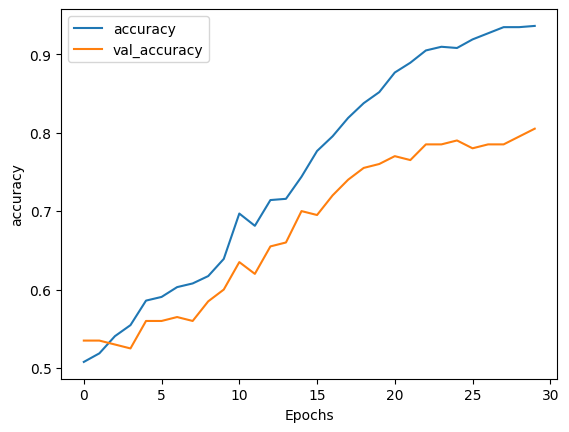

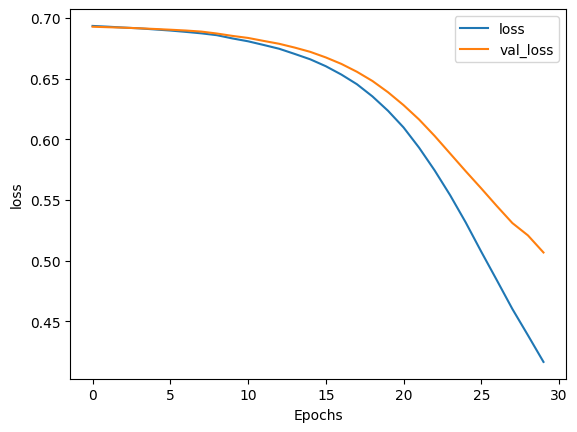

In [57]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Evaluate using test data

In [59]:
score = model.evaluate(test_sentences, test_labels, batch_size=64)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

3/3 [==============================] - 0s 5ms/step - loss: 0.4933 - accuracy: 0.8313

ACCURACY: 0.831250011920929
LOSS: 0.4932531416416168


# Save the Model

In [21]:
model_saved_path = "./models/"
tf.saved_model.save(model, model_saved_path)

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


## made with	&#x1F49D;

 Development : Load Model To Predict Value

In [22]:
new_model = tf.saved_model.load(model_saved_path)

In [23]:
new_model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x24768dd5890>

In [24]:
text_to_predict = ["Makanan sangat lezat dan bergizi cocok untuk liburan. Sangat direkomendasikan"]
print(text_to_predict)
prediction = new_model([text_to_predict])
prediction.numpy()[0][0]

['Makanan sangat lezat dan bergizi cocok untuk liburan. Sangat direkomendasikan']


0.96118504